<a href="https://colab.research.google.com/github/wlgml014/bdas_proj-4/blob/main/supervised/DL/012367id_CNN3unpool_ipynb_AE_Decoded_Earlystop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importing pandas
import numpy as np
import pandas as pd
from pandas.core.internals.blocks import F
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import neighbors, datasets
#from sklearn.inspection import DecisionBoundaryDisplay

import sklearn.metrics
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

In [ ]:
#col = [0,1,2,3,4,5,6,7,8,9,10,11]
#col = [1,3,4,5,6,7,8,9,10,11,12,13,14]
col = [4,5,6,7,10,11,12,15]
Dos= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/preprocessing_data/DoS_dataset_pre.csv',usecols = col)
Fuzzy=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/preprocessing_data/Fuzzy_dataset_pre.csv',usecols = col)
Rpm=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/preprocessing_data/RPM_dataset_pre.csv',usecols = col)
#,usecols = col

In [ ]:
Dataset = pd.concat((Dos, Fuzzy, Rpm))

In [ ]:
def sampling_func(data, n_sample):
    np.random.seed(10) #실행할 때마다 동일한 샘플을 추출하기 위해 random seed 고정
    N = len(data)
    sample = data.take(np.random.permutation(N)[:n_sample])
    return sample

SampledDataset = Dataset.groupby('Label', group_keys=False).apply(sampling_func, n_sample=250000)

In [ ]:
X = SampledDataset.drop(['Label'], axis=1)
y = SampledDataset['Label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,test_size = 0.2, random_state = 1)

In [ ]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# **AE**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Autoencoder 클래스 정의
class Autoencoder(BaseEstimator, TransformerMixin):
    def __init__(self, input_dim, encoding_dim, optimizer='adam', epochs=10, batch_size=32):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None

    def fit(self, X, y=None):
        input_layer = Input(shape=(self.input_dim,))
        encoded = Dense(self.encoding_dim, activation='relu')(input_layer)
        decoded = Dense(self.input_dim, activation='sigmoid')(encoded)

        self.autoencoder = Model(inputs=input_layer, outputs=decoded)
        self.autoencoder.compile(optimizer=self.optimizer, loss='mse')

        self.autoencoder.fit(X, X, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

        return self

    def transform(self, X):
        encoder = Model(inputs=self.autoencoder.input, outputs=self.autoencoder.get_layer(index=1).output)
        encoded_X = encoder.predict(X)
        decoder_input = Input(shape=(self.encoding_dim,))
        decoded_output = self.autoencoder.layers[-1](decoder_input)  # 마지막 레이어는 디코더 레이어입니다.
        decoder = Model(inputs=decoder_input, outputs=decoded_output)
        decoded_X = decoder.predict(encoded_X)
        return decoded_X

In [ ]:
autoencoder_params = {
    'input_dim': X_train.shape[1],
    'encoding_dim': 5,
    'optimizer': 'adam',
    'epochs': 10,
    'batch_size': 32
}


In [ ]:
print(X_train.shape[1])

7


In [ ]:
# Autoencoder 모델 학습
autoencoder = Autoencoder(
    input_dim=autoencoder_params['input_dim'],
    encoding_dim=autoencoder_params['encoding_dim'],
    optimizer=autoencoder_params['optimizer'],
    epochs=autoencoder_params['epochs'],
    batch_size=autoencoder_params['batch_size']
)
autoencoder.fit(X_train)

Autoencoder(encoding_dim=5, input_dim=7)

In [ ]:
# Autoencoder를 사용하여 특징 추출
X_train = autoencoder.transform(X_train)
X_test = autoencoder.transform(X_test)

6250/6250 [==============================] - 9s 1ms/step


In [ ]:
X_train

array([[1.94541330e-03, 8.41672227e-05, 1.00000000e+00, ...,
        1.00000000e+00, 6.25317395e-20, 8.78550828e-01],
       [6.45293668e-02, 1.88971858e-03, 3.62122140e-04, ...,
        1.06333955e-08, 9.99566674e-01, 5.39611974e-05],
       [9.89418626e-01, 1.62225485e-01, 1.00000000e+00, ...,
        9.99999344e-01, 1.13576249e-11, 9.99990165e-01],
       ...,
       [1.80173447e-04, 7.05564016e-05, 4.14576090e-04, ...,
        2.54076673e-04, 4.10352019e-04, 1.95969988e-05],
       [1.79509487e-04, 7.06038481e-05, 5.39913308e-04, ...,
        2.56241328e-04, 4.19047254e-04, 2.18627338e-05],
       [1.80148389e-04, 7.05975835e-05, 4.00130753e-04, ...,
        2.53936683e-04, 4.08844848e-04, 1.93092492e-05]], dtype=float32)

# **CNN**

In [ ]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization,Dropout,Dense,Flatten,Conv1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(7, 1)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 32)             128       
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense_2 (Dense)             (None, 16)                2576      
                                                                 
 dense_3 (Dense)             (None, 4)                 68        
                                                                 
Total params: 2,772
Trainable params: 2,772
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(X_train.shape[1])

7


In [ ]:
# 모델 컴파일
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

# 모델 학습
history = model.fit(X_train, y_train, epochs=100, callbacks = [early_stop], batch_size=16, validation_data=(X_test, y_test))

# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/100
50000/50000 [==============================] - 141s 3ms/step - loss: 0.1800 - accuracy: 0.9328 - val_loss: 0.1511 - val_accuracy: 0.9436
Epoch 2/100
50000/50000 [==============================] - 146s 3ms/step - loss: 0.1332 - accuracy: 0.9557 - val_loss: 0.1189 - val_accuracy: 0.9604
Epoch 3/100
50000/50000 [==============================] - 138s 3ms/step - loss: 0.1158 - accuracy: 0.9609 - val_loss: 0.1018 - val_accuracy: 0.9620
Epoch 4/100
50000/50000 [==============================] - 136s 3ms/step - loss: 0.0885 - accuracy: 0.9711 - val_loss: 0.0746 - val_accuracy: 0.9775
Epoch 5/100
50000/50000 [==============================] - 148s 3ms/step - loss: 0.0651 - accuracy: 0.9810 - val_loss: 0.0680 - val_accuracy: 0.9782
Epoch 6/100
50000/50000 [==============================] - 143s 3ms/step - loss: 0.0508 - accuracy: 0.9861 - val_loss: 0.0407 - val_accuracy: 0.9888
Epoch 7/100
50000/50000 [==============================] - 143s 3ms/step - loss: 0.0410 - accuracy: 0.9885

Text(0.5, 1.0, 'Training VS Validation Accuracy')

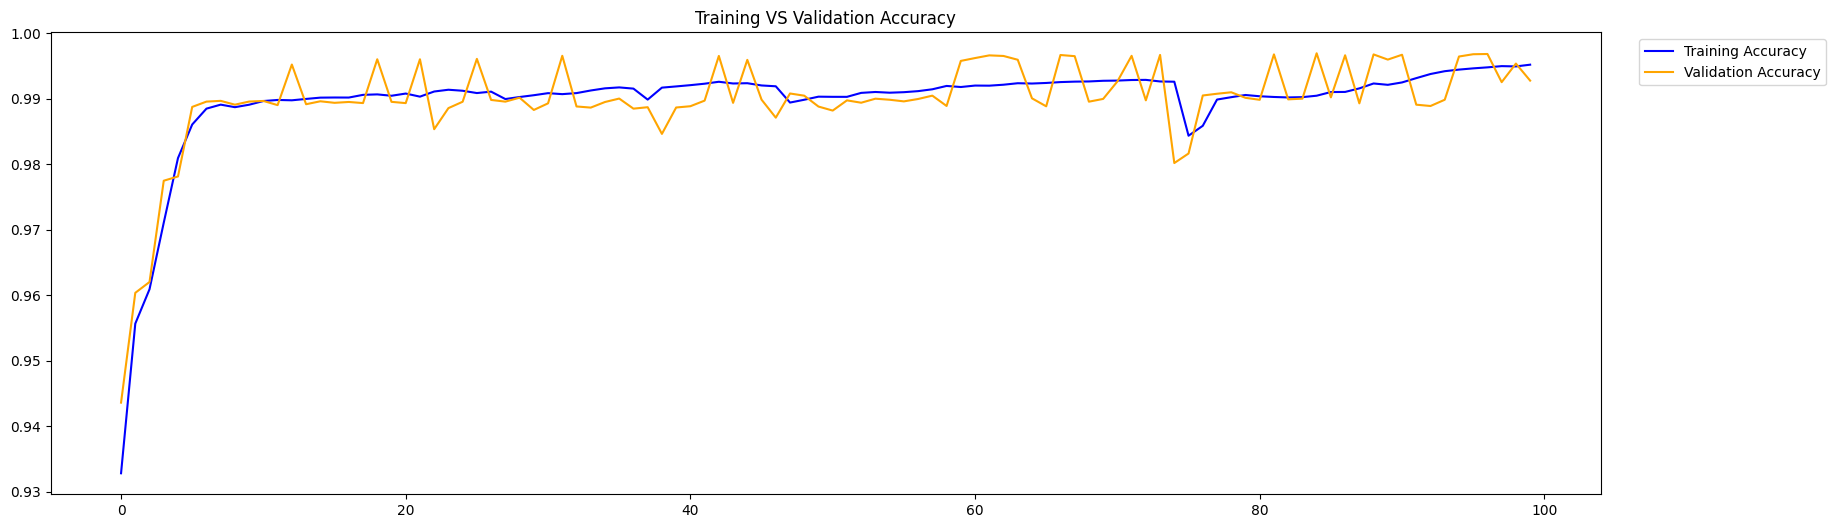

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs=range(len(acc))
plt.figure(figsize=(20, 6))

plt.plot(epochs, acc,color='blue', label='Training Accuracy')
plt.plot(epochs, val_acc,color='orange', label='Validation Accuracy')
plt.legend(bbox_to_anchor=(1.15, 1.0), loc='upper right')
plt.title('Training VS Validation Accuracy')


Text(0.5, 1.0, 'Training VS Validation Los')

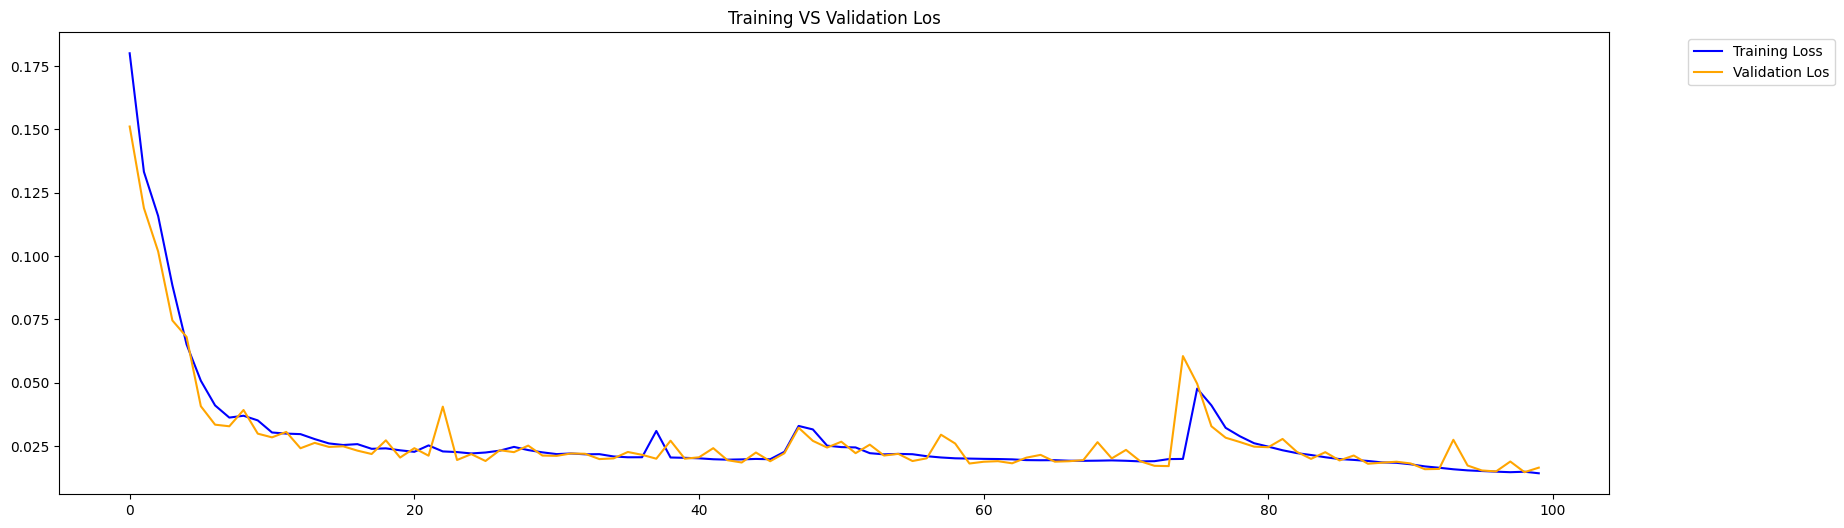

In [ ]:
los=history.history['loss']
val_los=history.history['val_loss']

epochs=range(len(los))
plt.figure(figsize=(20, 6))

plt.plot(epochs, los,color='blue', label='Training Loss')
plt.plot(epochs, val_los,color='orange', label='Validation Los')
plt.legend(bbox_to_anchor=(1.15, 1.0), loc='upper right')
plt.title('Training VS Validation Los')

In [ ]:
import seaborn
y_pred = model.predict(X_test)
print(y_pred)

6250/6250 [==============================] - 9s 1ms/step
[[9.7354239e-01 0.0000000e+00 2.6457543e-02 3.6410320e-36]
 [9.9997371e-01 0.0000000e+00 2.6227257e-05 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 9.9999994e-01 0.0000000e+00]
 ...
 [4.8159736e-21 0.0000000e+00 9.9999994e-01 0.0000000e+00]
 [3.7174484e-38 0.0000000e+00 9.9999994e-01 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 9.9999994e-01 0.0000000e+00]]


In [ ]:
y_pred_label = np.argmax(y_pred, axis=1)

print(y_pred_label)
y_test=np.squeeze(y_test.values)

[0 0 2 ... 2 2 2]


In [ ]:
cm = confusion_matrix(y_test, y_pred_label)

cm_matrix = pd.DataFrame(data=cm, columns=['Benign', 'Dos', 'Fuzzy','Rpm'],
                                 index=['Benign', 'Dos', 'Fuzzy','Rpm'])

print(cm)

[[49983     5    12     0]
 [ 1284 48716     0     0]
 [  137     2 49860     1]
 [    0     0     0 50000]]


<Axes: >

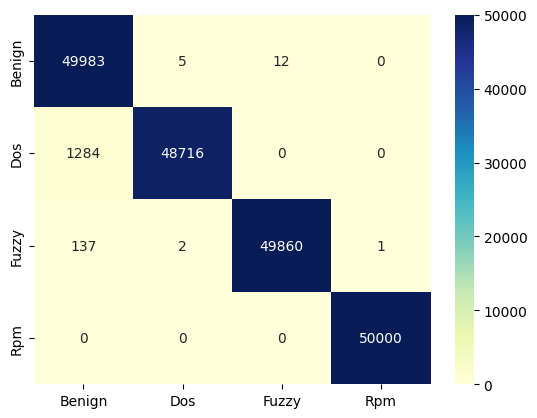

In [ ]:
import seaborn
seaborn.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
#evaluation for CNN

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_label))
print("Precision:",metrics.precision_score(y_test, y_pred_label, average='macro'))
print("Recall:",metrics.recall_score(y_test, y_pred_label, average='macro'))
print("F1_Score:",metrics.f1_score(y_test, y_pred_label, average='macro'))
print("Cohen_Kappa_Score:",sklearn.metrics.cohen_kappa_score(y_test, y_pred_label, labels=None, weights=None, sample_weight=None))
#print("MSE:",metrics.mean_squared_error(Y_Test,Y_Pred_svm))

Accuracy: 0.992795
Precision: 0.9929879879943826
Recall: 0.992795
F1_Score: 0.9928025396603763
Cohen_Kappa_Score: 0.9903933333333333
